## Collection of terrible Graphs.
Graphs are plots of model based dyna implementation, without any annotations bedcause I am lazy.


In [1]:
import jax
import matplotlib.pyplot as plt
from base_rl.higher_order import make_train, CONFIG
from base_rl.models import ActorCritic
from dyna.training import make_dyna_train_fn 
from model_based.transition_models import EquiModel, Model
from model_based.nn_model import NNCartPole 
from model_based.sample_env import make_expert_experience_fn, make_experience_fn, SARSDTuple
import model_based.train as mbt
from dyna.types import ActorCriticHyperParams, DynaHyperParams, TransitionModelHyperParams 
from dyna.global_config import make_hyp_cp
import numpy as np
import jax.numpy as jnp
import matplotlib

matplotlib.rcParams.update({'text.usetex': True, "font.family": "serif"})


# Train Expert  Transition Models:

In [2]:
rng = jax.random.PRNGKey(42)
expert = jax.jit(make_train(CONFIG, ActorCritic) )(rng)
ENV_NAME = "CartPole-v1"
EXP_TOTAL = 1e7
NUM_PARALLEL = 2000

train_state = expert["runner_state"][0]


128
976.0


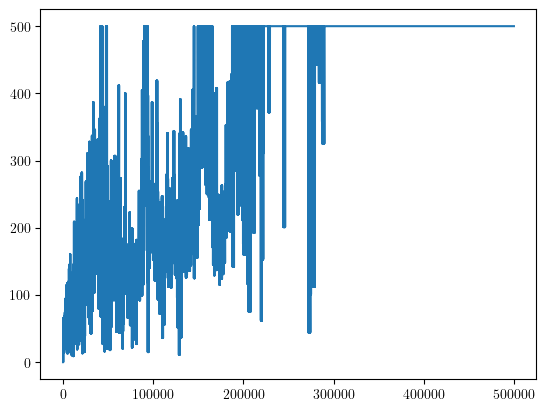

In [3]:
metrics = expert["metrics"]
returns = metrics[0]["returned_episode_returns"].reshape(-1)
plt.plot(returns)

In [4]:

expert_model_params = train_state.params
rng = jax.random.split(rng, NUM_PARALLEL)

random_experienc_fn = make_experience_fn(ENV_NAME, EXP_TOTAL // NUM_PARALLEL)
expert_experience_fn = make_expert_experience_fn(ENV_NAME, EXP_TOTAL//NUM_PARALLEL, expert_model_params)

random_experience = jax.vmap(random_experienc_fn)(rng)
expert_experience = jax.vmap(expert_experience_fn)(rng)

def flatten_shuff(rng, experience: SARSDTuple):
    _len= np.prod(experience.reward.shape)
    flat = jax.tree_map(lambda x: x.reshape(_len, -1), experience)
    perm = jax.random.permutation(rng, _len)
    shuff = jax.tree_map(lambda x: x.at[perm, ...].get(),flat)
    return shuff

rng = jax.random.PRNGKey(42)
expert_experience = flatten_shuff(rng, expert_experience)
random_experience = flatten_shuff(rng, random_experience)


/home/sean/ms_mono/.venv/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [5]:
expert_experience = expert_experience.join(random_experience)


In [6]:

NUM_EPOCHS=50
def make_model(hyp):
    train_data, val_data = expert_experience.partition(hyp.get_train_size(expert_experience))
    train_fn = mbt.make_train(hyp, train_data, val_data)
    out = jax.jit(train_fn)(rng)
    losses = out[1]
    train_state = out[0][1]
    return train_state.params, losses

hyp = mbt.HyperParams(epochs=NUM_EPOCHS, batch_size=512)
equi_hyp = mbt.HyperParams(model= EquiModel, epochs=NUM_EPOCHS, batch_size=512)


tm_params, tm_loss = make_model(hyp)
equi_params, equi_loss = make_model(equi_hyp)


2023-08-30 12:11:15.002169: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %negate.2561 = f32[4000000,4]{1,0} negate(f32[4000000,4]{1,0} %constant.2476), metadata={op_name="jit(train)/jit(main)/while/body/vmap(EquiModel)/C2Dense_0/neg" source_file="/home/sean/ms_mono/g_conv/g_conv/c2.py" source_line=24}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-08-30 12:11:18.112938: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4.110839164s
Constant folding an instruction is taking > 1s:

  %negate.2561 = f32[4000000,4]{1,0} negate(f32[4000000,4]{1,0} %const

In [7]:
import pickle
file_param = open("./params.pkl", "wb")
pickle.dump(tm_params, file_param)
file_equi= open("./params_equi.pkl", "wb")
pickle.dump(equi_params, file_equi)

# Sense Check model converges.


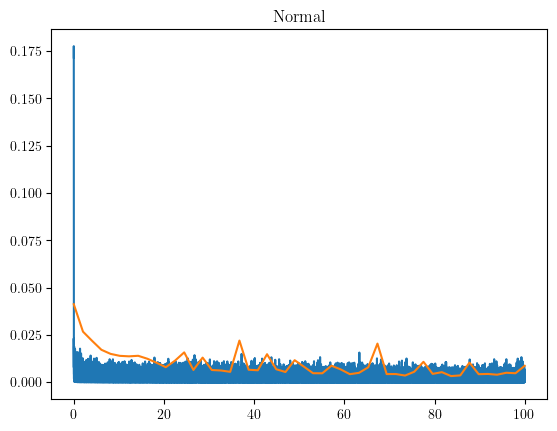

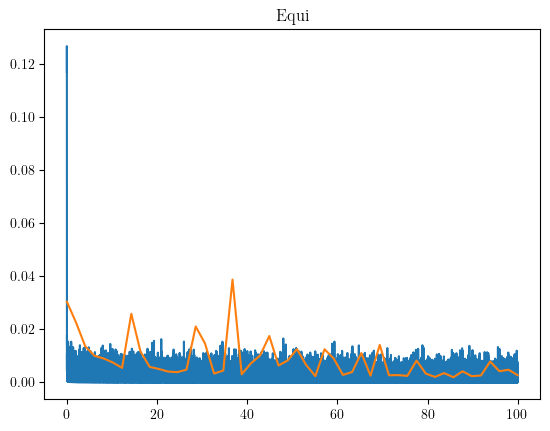

In [8]:
def plot_tm(loss, tit):
    train_loss = loss[0].train_loss.reshape(-1)
    val_loss = loss[0].val_loss.reshape(-1)
    def get_x(line, epch):
        return jnp.linspace(0, epch, num = len(line))
    plt.plot(get_x(train_loss, 100), train_loss)
    plt.plot(get_x(val_loss, 100), val_loss)
    plt.title(tit)
plot_tm(tm_loss, "Normal")
plt.show()
plot_tm(equi_loss, "Equi")

In [12]:
NUM_SEEDS = 8
PR = 1
base_dyna_hyp = make_hyp_cp(num_dyna_itr=50)

eqi_hyp = TransitionModelHyperParams(MODEL_FN=EquiModel, NUM_EPOCHS=0, PARAMS =equi_params) 
tm_hyp = TransitionModelHyperParams(MODEL_FN=Model, NUM_EPOCHS=0, PARAMS=tm_params)
no_m_hyp = TransitionModelHyperParams(USE_MODEL=False, NUM_EPOCHS=0, )
mf_hyp = base_dyna_hyp._replace( model_hyp=no_m_hyp)
dyna_hyp = base_dyna_hyp._replace(model_hyp =tm_hyp )
equi_hyp = base_dyna_hyp._replace(model_hyp=eqi_hyp)

rng = jax.random.PRNGKey(42)
rngs = jax.random.split(rng, NUM_SEEDS)
results= []
hyp = [mf_hyp, dyna_hyp, equi_hyp]
names = ['Model Free', 'Dyna', 'Equi-Dyna']
def stack_tuple_list(tup_list):
    items = [[] for _ in tup_list[0]]
    for tup in tup_list:
        for i, item in enumerate(tup):
            items[i].append(item)
    return tuple([jnp.stack(item) for item in items if item])

    
outer_results = {}
for pr in [1, 2, 4, 8]:
    results = []
    for h in hyp[:]:
        h = h._replace(PLANNING_RATIO=pr,)
        train_fn = jax.jit(jax.vmap(make_dyna_train_fn(h, NNCartPole)))
        rng_split_fn = jax.vmap(jax.random.split)
        def scan_train(rng_state, _ ):
            res = train_fn(rng_state)
            rng_state = rng_split_fn(rng_state)[:, :, -1]
            _, res_info = res
            return rng_state, res_info[1]
        _, result = jax.lax.scan(
            scan_train,
            rngs,
            None,
            length=4
        )
        results.append(result)
        del scan_train
    outer_results[pr] = results
        

Total_updates 486400


In [ ]:
import pickle
file = open("./dyna/expert.pkl", "wb")
pickle.dump(outer_results, file=file)


: 

: 

1 :
Dyna
111.53125 +- 11.877054
245.6875 +- 22.646849
500.0 +- 0.0
Equi-Dyna
112.40625 +- 13.898899
437.625 +- 20.021362
493.21875 +- 6.674452
2 :
Dyna
77.25 +- 6.2876987
253.53125 +- 23.541351
494.09375 +- 5.813232
Equi-Dyna
119.96875 +- 12.159541
479.78125 +- 13.896079
500.0 +- 0.0
4 :
Dyna
57.34375 +- 7.9477797
212.3125 +- 23.37581
473.875 +- 16.183924
Equi-Dyna
114.5625 +- 12.82735
486.21875 +- 10.62424
500.0 +- 0.0
8 :
Dyna
54.21875 +- 9.123794
187.3125 +- 28.255888
405.34375 +- 27.780302
Equi-Dyna
119.78125 +- 13.17659
498.21875 +- 1.753197
489.78125 +- 10.057814


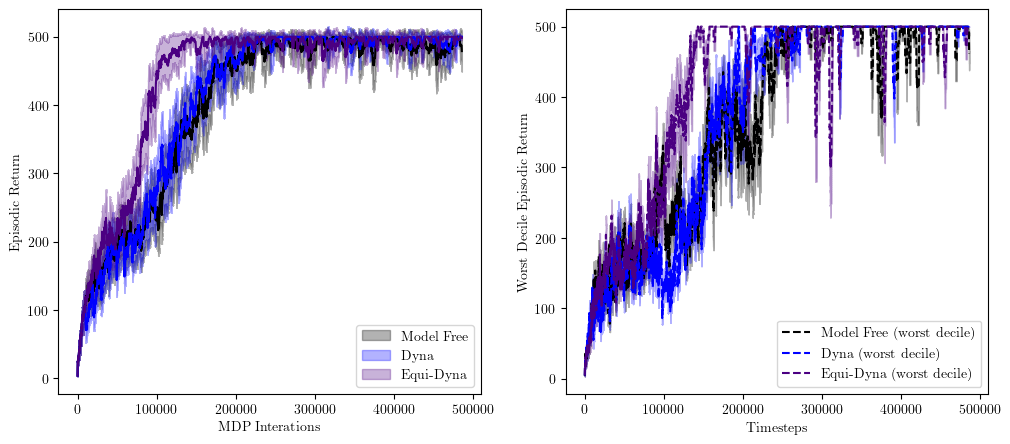

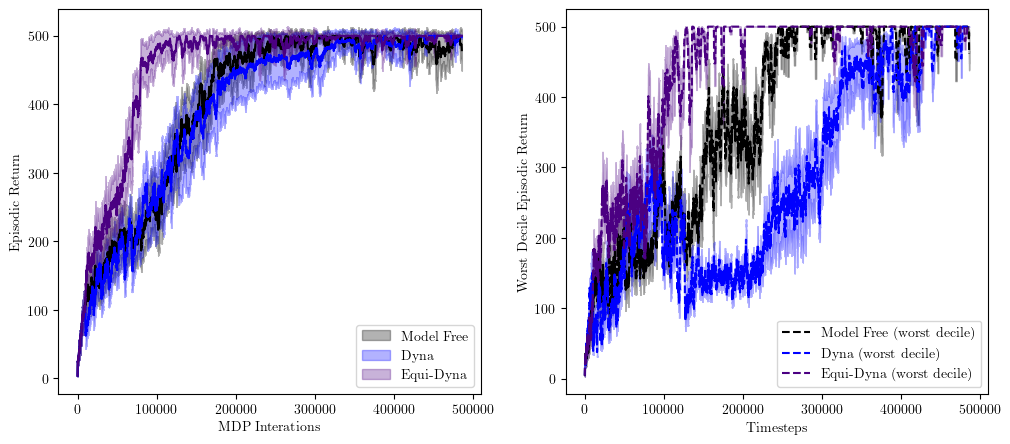

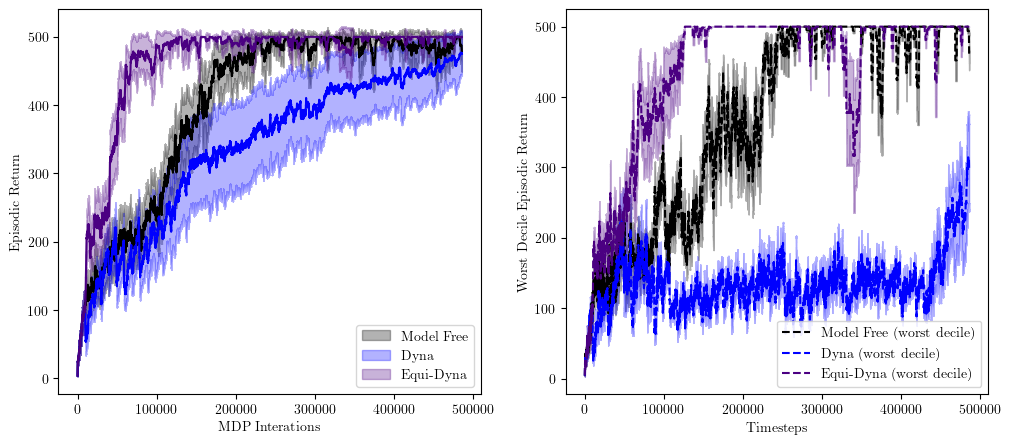

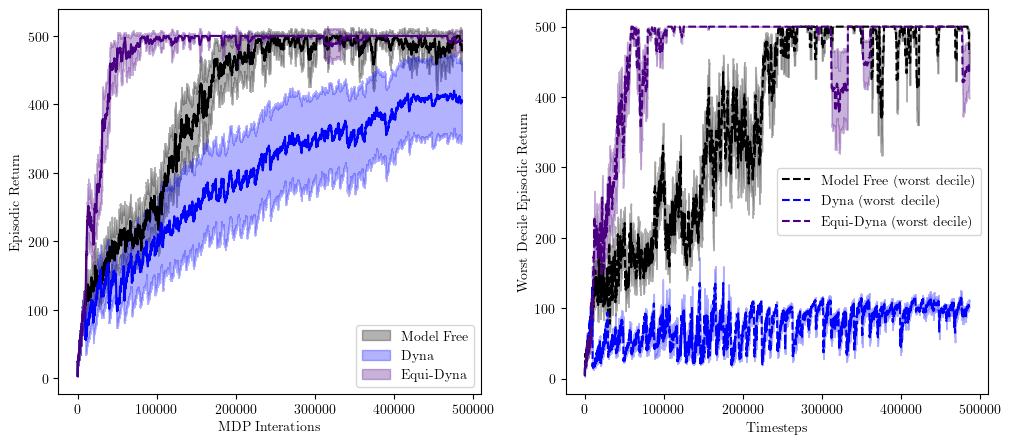

In [13]:
num_seeds = NUM_SEEDS * 4
def moving_average(x, w=100):
    return np.convolve(x, np.ones(w), "valid") / w
for pr, results in outer_results.items():
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    cs = ["black", "blue", "indigo"]
    print(pr, ":")
    
    for res, name, c in zip(results, names, cs):
        # traj = res[1]
        traj = res
        # acting_returns = 1 - traj.info["returned_episode_returns"]/ 500
        # ax[0].set_ylim(1e-2, 1)
        # ax[1].set_ylim(1e-2, 1)
        acting_returns = traj.info["returned_episode_returns"]
        acting_returns = acting_returns.reshape(np.prod(acting_returns.shape[:2]), -1)
        acting_returns_mean = jnp.mean(acting_returns, axis=0).reshape(-1)
        acting_returns_std = jnp.std(acting_returns, axis=0).reshape(-1)/ np.sqrt(NUM_SEEDS)
        acting_returns_mean = moving_average(acting_returns_mean)
        acting_returns_std = moving_average(acting_returns_std)
        lower = acting_returns_mean - acting_returns_std
        upper = acting_returns_mean + acting_returns_std
        x = jnp.arange(len(acting_returns_mean))
        ax[0].plot(acting_returns_mean, color=c)
        ax[0].fill_between(jnp.arange(len(acting_returns_mean)), lower, upper, alpha=0.3,  label=name, color=c, )
        ax[0].legend()    
        ax[0].set_xlabel("MDP Interations")
        ax[0].set_ylabel("Episodic Return")
        cumulative_returns = np.cumsum(acting_returns, axis=1)[:, -1]
        worst_decile = np.quantile(cumulative_returns, 0.1)
        worst_mean = acting_returns[cumulative_returns < worst_decile].mean(axis=0)
        worst_std = acting_returns[cumulative_returns < worst_decile].std(
            axis=0
        ) / np.sqrt(NUM_SEEDS)
        worst_upper = worst_mean + worst_std
        worst_lower = worst_mean - worst_std
        ax[1].plot(
            x,
            moving_average(worst_mean),
            label=f"{name} (worst decile)",
            linestyle="--",
            color=c,
        )
        ax[1].fill_between(
            x,
            moving_average(worst_lower),
            moving_average(worst_upper),
            alpha=0.3,
            color=c,
        )
        ax[1].set_xlabel("Timesteps")
        ax[1].set_ylabel("Worst Decile Episodic Return")
        if name != "Model Free":
            print(name)
            print(acting_returns.mean(axis=0)[10_000],"+-", acting_returns.std(axis=0)[10_000]/np.sqrt(num_seeds))
            print(acting_returns.mean(axis=0)[100_000],"+-", acting_returns.std(axis=0)[100_000]/np.sqrt(num_seeds))
            print(acting_returns.mean(axis=0)[-1],"+-", acting_returns.std(axis=0)[-1]/np.sqrt(num_seeds))


    ax[0].legend()
    ax[1].legend()
    fig.savefig(f"../msc_thesis/Figures/Expert_dyna_cp_pr{pr}")




1 :
Dyna
111.53125 +- 11.877054
245.6875 +- 22.646849
500.0 +- 0.0
2 :
4 :
8 :
Equi-Dyna
119.78125 +- 13.17659
498.21875 +- 1.753197
489.78125 +- 10.057814


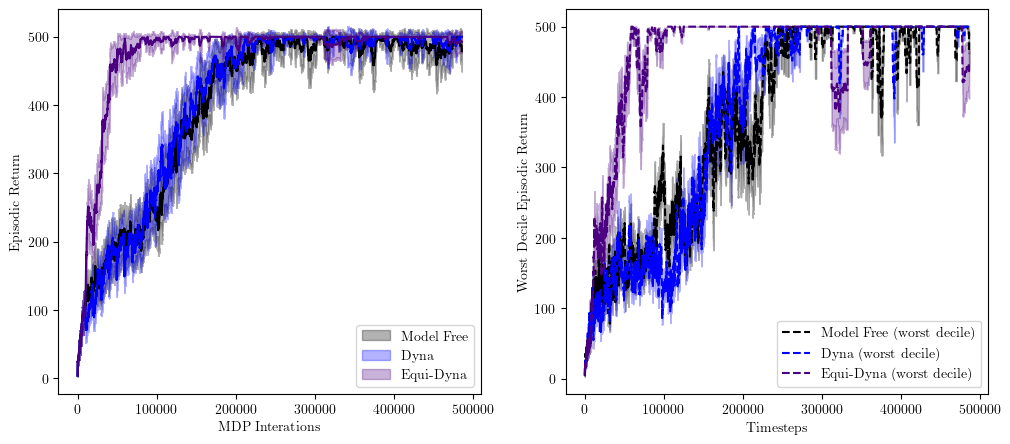

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for pr, results in outer_results.items():
    cs = ["black", "blue", "indigo"]
    print(pr, ":")
    
    for res, name, c in zip(results, names, cs):
        if (pr == 8 and name == "Equi-Dyna") or (pr == 1 and name == "Dyna") or (pr ==1 and name == "Model Free"):

            # traj = res[1]
            traj = res
            # acting_returns = 1 - traj.info["returned_episode_returns"]/ 500
            # ax[0].set_ylim(1e-2, 1)
            # ax[1].set_ylim(1e-2, 1)
            acting_returns = traj.info["returned_episode_returns"]
            acting_returns = acting_returns.reshape(np.prod(acting_returns.shape[:2]), -1)
            acting_returns_mean = jnp.mean(acting_returns, axis=0).reshape(-1)
            acting_returns_std = jnp.std(acting_returns, axis=0).reshape(-1)/ np.sqrt(NUM_SEEDS)
            acting_returns_mean = moving_average(acting_returns_mean)
            acting_returns_std = moving_average(acting_returns_std)
            lower = acting_returns_mean - acting_returns_std
            upper = acting_returns_mean + acting_returns_std
            x = jnp.arange(len(acting_returns_mean))
            ax[0].plot(acting_returns_mean, color=c)
            ax[0].fill_between(jnp.arange(len(acting_returns_mean)), lower, upper, alpha=0.3,  label=name, color=c, )
            ax[0].legend()    
            ax[0].set_xlabel("MDP Interations")
            ax[0].set_ylabel("Episodic Return")
            cumulative_returns = np.cumsum(acting_returns, axis=1)[:, -1]
            worst_decile = np.quantile(cumulative_returns, 0.1)
            worst_mean = acting_returns[cumulative_returns < worst_decile].mean(axis=0)
            worst_std = acting_returns[cumulative_returns < worst_decile].std(
                axis=0
            ) / np.sqrt(NUM_SEEDS)
            worst_upper = worst_mean + worst_std
            worst_lower = worst_mean - worst_std
            ax[1].plot(
                x,
                moving_average(worst_mean),
                label=f"{name} (worst decile)",
                linestyle="--",
                color=c,
            )
            ax[1].fill_between(
                x,
                moving_average(worst_lower),
                moving_average(worst_upper),
                alpha=0.3,
                color=c,
            )
            ax[1].set_xlabel("Timesteps")
            ax[1].set_ylabel("Worst Decile Episodic Return")
            if name != "Model Free":
                print(name)
                print(acting_returns.mean(axis=0)[10_000],"+-", acting_returns.std(axis=0)[10_000]/np.sqrt(num_seeds))
                print(acting_returns.mean(axis=0)[100_000],"+-", acting_returns.std(axis=0)[100_000]/np.sqrt(num_seeds))
                print(acting_returns.mean(axis=0)[-1],"+-", acting_returns.std(axis=0)[-1]/np.sqrt(num_seeds))



        ax[0].legend()
        ax[1].legend()
        fig.savefig(f"../msc_thesis/Figures/Expert_dyna_cp_best.png")




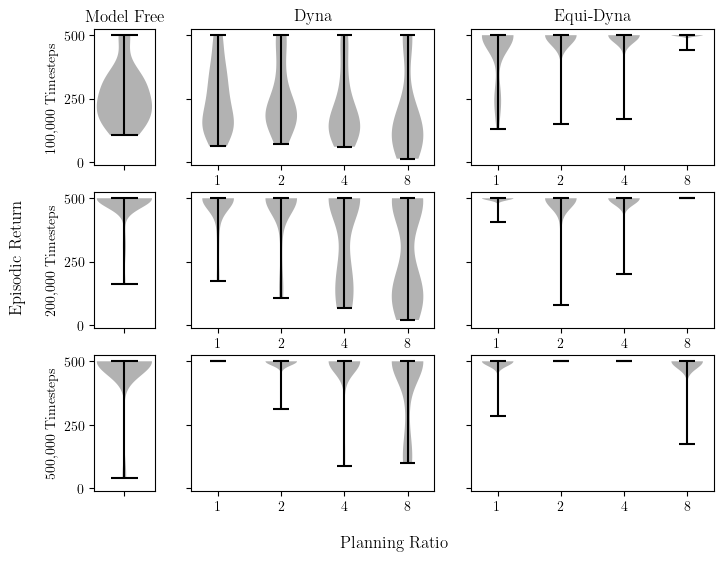

In [14]:
results_dict = {"first": {}, "second": {}, "last": {}}
for pr, results in outer_results.items():
    for res, name, c in zip(results, names, cs):
        # traj = res[1]
        traj = res
        # acting_returns = 1 - traj.info["returned_episode_returns"]/ 500
        # ax[0].set_ylim(1e-2, 1)
        # ax[1].set_ylim(1e-2, 1)
        acting_returns = traj.info["returned_episode_returns"]
        acting_returns = acting_returns.reshape(np.prod(acting_returns.shape[:2]), -1)
        acting_returns_mean = jnp.mean(acting_returns, axis=0).reshape(-1)
        acting_returns_std = jnp.std(acting_returns, axis=0).reshape(-1)/ np.sqrt(NUM_SEEDS)
        acting_returns_mean = moving_average(acting_returns_mean)
        acting_returns_std = moving_average(acting_returns_std)
        lower = acting_returns_mean - acting_returns_std
        upper = acting_returns_mean + acting_returns_std
        x = jnp.arange(len(acting_returns_mean))
        first = acting_returns[:, 100_000]
        second = acting_returns[:, 200_000]
        last = acting_returns[:, -1]
        results_dict["first"][(name, pr)] = first
        results_dict["second"][(name, pr)] = second
        results_dict["last"][(name, pr)] = last
        
fig, ax = plt.subplots(3,3, figsize=(8, 6), sharey=True, width_ratios=[1, 4, 4])
mappings = {"first": "100,000", "second": "200,000", "last": "500,000"}
for i, step in enumerate(results_dict):
    values = {name : [results_dict[step][(name, pr)] for pr in outer_results] for name in names}
    for j, (name, c) in enumerate(zip(names, cs)):
        if name == "Model Free":
            vp = ax[i, j].violinplot(values[name][0], widths=[0.2])
            ax[i,j].set_xticks([1], [None])
        else: 
            vp =ax[i, j].violinplot(values[name], )
            ax[i, j].set_xticks([1, 2,3, 4], [1, 2, 4, 8])
            ax[i, j].set_yticks([0,250, 500],)
        ax[0, j].set_title(name)
        for part in vp["bodies"]:
            part.set_facecolor("black")
        for partname in ('cbars','cmins','cmaxes',):
            vp[partname].set_color("black")


    ax[i, 0].set_ylabel(mappings[step] + " Timesteps")
fig.supylabel("Episodic Return")
fig.supxlabel("Planning Ratio")
# fig.tight_layout()
fig.savefig("../msc_thesis/Figures/violin_cp_expert.png")
        
    

In [ ]:
for info, name in zip(results[1:], names[1:]):
    m_loss= info[-1]
    plt.plot(m_loss.mean(axis=(0, 1)).reshape(-1),  label=name)
    print(jnp.min(m_loss.mean(axis=(0, 1)).reshape(-1)))
    
plt.legend()

AttributeError: 'dict' object has no attribute 'mean'